<a id="top"></a>

In the next Demo we will show how to
<h3 id="pearl_noise_texture">Create the Perlin Noise texture</h3>

<a href="../PearlNoiseProject.ipynb">Back To Main</a>

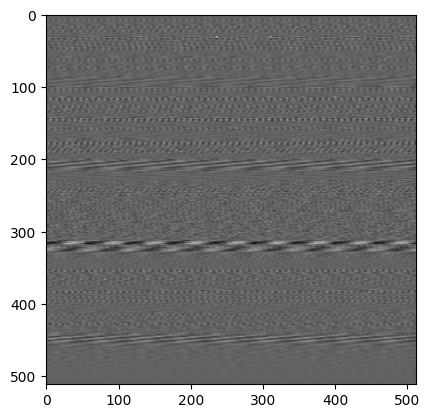

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from skimage.transform import resize
from ipywidgets import interactive
import IPython.display as ipd

# Load the wav file
samplerate, data = wavfile.read('Soft Piano Music_16000_mono.wav')

# Normalize the data
normalized_data = (data - np.min(data)) / np.ptp(data)

# Define the desired size of the image (you can change this as needed)
image_size = (512, 512)

# Find the nearest perfect square less than the number of data points
perfect_square = int(np.floor(np.sqrt(len(normalized_data)))) ** 2

# Truncate the data and reshape it into a square array
square_data = normalized_data[:perfect_square].reshape((int(np.sqrt(perfect_square)), int(np.sqrt(perfect_square))))

# Resize the square data to match the image size
resized_data = resize(square_data, image_size, mode='reflect')

# Function to plot the resized data
def plot_audio_data():
    plt.imshow(resized_data, cmap='gray')
    plt.show()

plot_audio_data()

# Display the audio file
ipd.Audio('Soft Piano Music_16000_mono.wav')


In [ ]:
import numpy as np
from scipy.io.wavfile import write
from IPython.display import Audio
from noise import snoise2
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Constants
fs = 44100 # sample rate 
T = 5.0    # seconds
t = np.linspace(0, T, int(T*fs), False) # time variable

# Function to generate Perlin Noise values for a given grid size and resolution
def generate_noise(width, height, resolution, octaves=1, persistence=0.5, lacunarity=2.0, base=0.0):
    x_coords = np.linspace(0, resolution, width) # np.linspace returns evenly spaced numbers over a specified interval (resolution)
    y_coords = np.linspace(0, resolution, height)
    return np.array([[snoise2(x, y, octaves=octaves, persistence=persistence, lacunarity=lacunarity, base=base) for x in x_coords] for y in y_coords])

def create_audio_from_noise(colormap, width, height, resolution, octaves, persistence, lacunarity, base):
    # Generate perlin noise
    noise = generate_noise(width, height, resolution, octaves, persistence, lacunarity, base)
    
    # Visualize the noise
    plt.imshow(noise, cmap=colormap, interpolation='lanczos', origin='lower')
    plt.colorbar()
    plt.title("2D Perlin Noise")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
    
    # Flatten the noise
    flat_noise = noise.flatten()

    # Normalize the noise to be between -1 and 1
    normalized_noise = 2.0*(flat_noise - np.min(flat_noise))/np.ptp(flat_noise) - 1
    
    # Rescale the normalized noise to match the length of the oscillator
    rescaled_noise = np.interp(t, np.linspace(0, T, len(normalized_noise)), normalized_noise)
    
    # Generate a sinusoidal oscillator
    oscillator = np.sin(440*t)
    
    # Modulate the amplitude of the oscillator by the noise
    modulated_signal = oscillator * rescaled_noise
    
    # Play the audio
    return Audio(modulated_signal, rate=fs)

# Create interactive sliders
interact(create_audio_from_noise,
        colormap=widgets.Dropdown(options=plt.colormaps(), value="bone", description="Colormap:"),
         width=widgets.IntSlider(min=50, max=1000, step=10, value=200, description="Width:"),
         height=widgets.IntSlider(min=50, max=1000, step=10, value=200, description="Height:"),
         resolution=widgets.FloatSlider(min=1, max=30, step=0.1, value=15, description="Resolution:"),
         octaves=widgets.IntSlider(min=1, max=10, step=1, value=1, description="Octaves:"),
         persistence=widgets.FloatSlider(min=0.1, max=1, step=0.1, value=0.5, description="Persistence:"),
        lacunarity=widgets.FloatSlider(min=1, max=10, step=0.1, value=2.0, description="Lacunarity:"),
         base=widgets.FloatSlider(min=0, max=100, step=1, value=0, description="Base:"))



interactive(children=(Dropdown(description='Colormap:', index=40, options=('magma', 'inferno', 'plasma', 'viri…

<function __main__.create_audio_from_noise(colormap, width, height, resolution, octaves, persistence, lacunarity, base)>

In [72]:
from sklearn.cluster import KMeans
from PIL import Image
import numpy as np
from scipy.io.wavfile import write
from IPython.display import Audio
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Load image
img = Image.open('../images/nature.jpg')
data = np.array(img)

# Flatten the image and take the mean of the RGB values
data_flattened = data.reshape(-1, 3).mean(axis=1)

# Apply KMeans clustering to group similar pixels together
kmeans = KMeans(n_clusters=5)
kmeans.fit(data_flattened.reshape(-1, 1))

# Get the cluster centers and map them to the range 20-20000 Hz
freqs = np.interp(kmeans.cluster_centers_, (data_flattened.min(), data_flattened.max()), (20, 20000))

# Function to generate and visualize audio
def generate_audio(freq_scale, amplitude, duration):
    # Generate a 5 second audio signal for each frequency
    fs = 44100 # sample rate 
    T = duration    # seconds
    t = np.linspace(0, T, int(T*fs), False) # time variable

    # Create audio for each cluster
    audio = np.concatenate([np.sin((f*freq_scale)*t) for f in freqs])

    # Adjust amplitude
    audio *= amplitude

    # Normalize to 16-bit range
    audio *= 32767 / np.max(np.abs(audio))
    # Convert to 16-bit data
    audio = audio.astype(np.int16)

    # Compute the FFT of the audio signal
    N = len(audio)
    yf = fft(audio)
    xf = fftfreq(N, 1 / fs)

    # Plot the FFT of the audio signal
    plt.figure(figsize=(12, 4))
    plt.plot(xf[:N//2], np.abs(yf[:N//2])) # We only plot the first half of the FFT, as it is symmetric
    plt.title("Frequency Spectrum of Audio Signal")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.show()

    # Play the audio
    return Audio(audio, rate=fs)

# Create interactive sliders
interact(generate_audio,
         freq_scale=widgets.FloatSlider(min=0.1, max=2.0, step=0.1, value=1.0, description="Frequency scale:"),
         amplitude=widgets.FloatSlider(min=0.1, max=1.0, step=0.1, value=0.5, description="Amplitude:"),
         duration=widgets.IntSlider(min=1, max=10, step=1, value=5, description="Duration (s):"))


c:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


interactive(children=(FloatSlider(value=1.0, description='Frequency scale:', max=2.0, min=0.1), FloatSlider(va…

<function __main__.generate_audio(freq_scale, amplitude, duration)>

In [21]:
import numpy as np
from scipy.io.wavfile import write
from perlin_noise import PerlinNoise
from ipywidgets import interact
import IPython.display as ipd

# Define the size of the image
image_size = (512, 512)

def generate_and_play_noise(octaves):
    # Initialize the Perlin noise generator
    noise = PerlinNoise(octaves=octaves, seed=np.random.randint(1,100))

    # Generate the Perlin noise
    perlin_noise = np.zeros(image_size)
    for row in range(image_size[0]):
        for col in range(image_size[1]):
            perlin_noise[row][col] = noise([row/image_size[0], col/image_size[1]])

    # Normalize the Perlin noise to between -1 and 1
    normalized_noise = 2*(perlin_noise - np.min(perlin_noise))/np.ptp(perlin_noise) - 1

    # Flatten the normalized noise to a 1D array
    flattened_noise = normalized_noise.flatten()

    # Convert the flattened noise to 16-bit PCM WAV data
    pcm_noise = np.int16(flattened_noise * 32767)

    # Write the PCM WAV data to a file
    write('perlin_noise.wav', 44100, pcm_noise)
    
    plt.imshow(normalized_noise, cmap='gray')
    
    return ipd.Audio('perlin_noise.wav')

interact(generate_and_play_noise, octaves=(1, 10, 1))


interactive(children=(IntSlider(value=5, description='octaves', max=10, min=1), Output()), _dom_classes=('widg…

<function __main__.generate_and_play_noise(octaves)>